# Movie reviews

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Movie reviews. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

You are encouraged to create features beyond those available in the feature extraction documentation. Possibilities include the length of the comment/review, its grammar, punctuation, etc.

The Machine Learning task: 
This is a classification task. You will predict **Sentiment**, which is equal to **1 if the movie review is a “good” review** or **0 if it is not a “good” review**. 

Variables that should never be on the X side of the equation: 
- id
- Sentiment
- OR ANY VARIATION OF THESE!


Your work will be assessed on: 
- how accurately your model classifies on a test set
- how well your model generalizes
- the organization and documentation of your Jupyter Notebooks
- communication of your work in class reflections and final presentations
- model improvement over the semester
-  -10 points if you use a random_seed of 74 in your train/test data split

## import libraries we will use:

In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

using NLTK, let's explore the data

## Local BinaryClassificationPerformance()

In [2]:
# my_measures
class BinaryClassificationPerformance():
    '''Performance measures to evaluate the fit of a binary classification model, v1.02'''
    
    def __init__(self, predictions, labels, desc, probabilities=None):
        '''Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y'''
        '''probabilities-optional, probability that Y is equal to True'''
        self.probabilities = probabilities
        self.performance_df = pd.concat([pd.DataFrame(predictions), pd.DataFrame(labels).reset_index(drop=True)], axis=1, ignore_index=True)
        self.performance_df.columns = ['preds', 'labls']
        self.desc = desc
        self.performance_measures = {}
        self.image_indices = {}
  
    def compute_measures(self):
        '''Compute performance measures defined by Flach p. 57'''
        self.performance_measures['Pos'] = self.performance_df['labls'].sum()
        self.performance_measures['Neg'] = self.performance_df['labls'].shape[0] - self.performance_df['labls'].sum()
        self.performance_measures['TP'] = ((self.performance_df['preds'] == True) & (self.performance_df['labls'] == True)).sum()
        self.performance_measures['TN'] = ((self.performance_df['preds'] == False) & (self.performance_df['labls'] == False)).sum()
        self.performance_measures['FP'] = ((self.performance_df['preds'] == True) & (self.performance_df['labls'] == False)).sum()
        self.performance_measures['FN'] = ((self.performance_df['preds'] == False) & (self.performance_df['labls'] == True)).sum()
        self.performance_measures['Accuracy'] = (self.performance_measures['TP'] + self.performance_measures['TN']) / (self.performance_measures['Pos'] + self.performance_measures['Neg'])
        self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])
        self.performance_measures['Recall'] = self.performance_measures['TP'] / self.performance_measures['Pos']
        self.performance_measures['desc'] = self.desc

    def img_indices(self):
        '''Get the indices of true and false positives to be able to locate the corresponding images in a list of image names'''
        self.performance_df['tp_ind'] = ((self.performance_df['preds'] == True) & (self.performance_df['labls'] == True))
        self.performance_df['fp_ind'] = ((self.performance_df['preds'] == True) & (self.performance_df['labls'] == False))
        self.image_indices['TP_indices'] = np.where(self.performance_df['tp_ind']==True)[0].tolist()
        self.image_indices['FP_indices'] = np.where(self.performance_df['fp_ind']==True)[0].tolist()

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [3]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module __main__:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object

In [4]:
movie_data = pd.read_csv('../week04/final_data/moviereviews_train.tsv', sep='\t')

In [7]:
movie_data.describe()

,sentiment
count,25000.00000
mean,0.50000
std,0.50001
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


In [8]:
movie_data.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [9]:
sample_review=movie_data['review'][0]
print(sample_review)

With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally star

## Basic features:

- How long is the text?

In [10]:
sample_review.split()

['With',
 'all',
 'this',
 'stuff',
 'going',
 'down',
 'at',
 'the',
 'moment',
 'with',
 'MJ',
 "i've",
 'started',
 'listening',
 'to',
 'his',
 'music,',
 'watching',
 'the',
 'odd',
 'documentary',
 'here',
 'and',
 'there,',
 'watched',
 'The',
 'Wiz',
 'and',
 'watched',
 'Moonwalker',
 'again.',
 'Maybe',
 'i',
 'just',
 'want',
 'to',
 'get',
 'a',
 'certain',
 'insight',
 'into',
 'this',
 'guy',
 'who',
 'i',
 'thought',
 'was',
 'really',
 'cool',
 'in',
 'the',
 'eighties',
 'just',
 'to',
 'maybe',
 'make',
 'up',
 'my',
 'mind',
 'whether',
 'he',
 'is',
 'guilty',
 'or',
 'innocent.',
 'Moonwalker',
 'is',
 'part',
 'biography,',
 'part',
 'feature',
 'film',
 'which',
 'i',
 'remember',
 'going',
 'to',
 'see',
 'at',
 'the',
 'cinema',
 'when',
 'it',
 'was',
 'originally',
 'released.',
 'Some',
 'of',
 'it',
 'has',
 'subtle',
 'messages',
 'about',
 "MJ's",
 'feeling',
 'towards',
 'the',
 'press',
 'and',
 'also',
 'the',
 'obvious',
 'message',
 'of',
 'drugs',
 

In [11]:
len(sample_review.split())

433

In [12]:
# let's clean it for < br/>
sample_review = sample_review.replace("<br />", " ").replace("\\", "").replace("\'", "'")

In [13]:
sample_review

"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.  Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.  The actual feature film bit when it finally starts is only on for 2

In [14]:
movie_data['review'][5]

'I dont know why people think this is such a bad movie. Its got a pretty good plot, some good action, and the change of location for Harry does not hurt either. Sure some of its offensive and gratuitous but this is not the only movie like that. Eastwood is in good form as Dirty Harry, and I liked Pat Hingle in this movie as the small town cop. If you liked DIRTY HARRY, then you should see this one, its a lot better than THE DEAD POOL. 4/5'

In [15]:
negative_words=["stupid", "liar", "guilty", "hate", 
                "boring", "bad", "not", "hates", "bad", 
                "terrible", "waste", "hated", "awful", "dumb", "idiot",
               "badly", "mediocore", "ridiculous", "nonsense", "disaster", "monstrously",
               "ill"]
positive_words=["great", "loved", "fun", "cute", "entertaining", "good", "wholesome",
               "nice", "impressive", "funny", "classic", "pretty", "beautiful"]
# count the occurance of any of the posittive words iin the text:

        
        
def getOccurrences(str, word):
    # split the string by spaces in a
    a = str.split(" ")
 
    # search for pattern in a
    count = 0
    for i in range(0, len(a)):
         
        # if match found increase count
        if (word == a[i]):
           count = count + 1
            
    return count 

def word_test(sample_review):
    tot_pos=0
    tot_neg=0
    for word in range(0, len(negative_words)):
        num=getOccurrences(sample_review, negative_words[word])
        if num>0:
            tot_neg+=num
    for word in range(0, len(positive_words)):
        num=getOccurrences(sample_review, positive_words[word])
        if num>0:
            tot_pos+=num
    if (tot_pos+tot_neg)==0:
        return 1.0
    else:
#     print(tot_pos, tot_neg)
        return((tot_pos-tot_neg) / (tot_pos+tot_neg))

word_test(sample_review)

-0.42857142857142855

In [16]:
l=movie_data['review'].str.split(' ').str.len()
type(l)

pandas.core.series.Series

In [17]:
# list of strings
lst = []
# Calling DataFrame constructor on list
# df = pd.DataFrame(lst)
# df
for i in range(0, len(movie_data['review'])): 
    n= word_test(movie_data['review'][i])
    lst.append(n+1)
    
#     print("movie_data['sent_count']",n)
df = pd.DataFrame(lst)
df  
# word_test(movie_data['review'])

,0
0,0.571429
1,1.600000
2,0.000000
3,0.000000
4,1.000000
...,...
24995,2.000000
24996,1.500000
24997,1.000000
24998,0.000000


## NLTK EXPLORATION

In [18]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from nltk import tokenize
lines_list = tokenize.sent_tokenize(sample_review)

In [19]:
lines_list

["With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again.",
 'Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent.',
 'Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released.',
 "Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.",
 'Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring.',
 'Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.',
 'The actual feature film bit when it finally 

In [20]:
for sentence in lines_list:
    sid = SentimentIntensityAnalyzer()
    print(sentence)
    ss = sid.polarity_scores(sentence)
    for k in sorted(ss):
        print('{0}: {1}, '.format(k, ss[k]), end='')
        print()


With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again.
compound: -0.3182, 
neg: 0.071, 
neu: 0.929, 
pos: 0.0, 
Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent.
compound: 0.5563, 
neg: 0.075, 
neu: 0.699, 
pos: 0.226, 
Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released.
compound: 0.0, 
neg: 0.0, 
neu: 1.0, 
pos: 0.0, 
Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.
compound: -0.4588, 
neg: 0.14, 
neu: 0.8, 
pos: 0.06, 
Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring.
compound: -0.5574, 
neg: 0

In [23]:
from nltk.tokenize.punkt import PunktSentenceTokenizer, PunktParameters

punkt_params = PunktParameters()
punkt_params.abbrev_types = set(['Mr', 'Mrs', 'LLC'])
tokenizer = PunktSentenceTokenizer(punkt_params)

def get_sentiment_given_paragraph(text):
#     replace <br /><br /> with ' '
    cleaned_sample=text.replace('<br />', ' ')
    tokens = tokenizer.tokenize(cleaned_sample)
    sentiment=0
    for sentence in tokens:
        sid = SentimentIntensityAnalyzer()
        ss = sid.polarity_scores(sentence)
        sentiment+=ss['compound']
    return(sentiment)
right=0
wrong=0
# check if it works:
for i in range(0,25000):
    verdict=get_sentiment_given_paragraph(movie_data['review'][i])
#     print(get_sentiment_given_paragraph(movie_data['review'][i]))
#     print(movie_data['sentiment'][i])
    if (verdict>0 and movie_data['sentiment'][i] == 1 ) or (verdict<0 and movie_data['sentiment'][i] == 0 ):
        right+=1
    else:
        wrong+=1
print('right:', right, 'wrong:', wrong, 'total:', right+wrong)

right: 17668 wrong: 7332 total: 25000


In [24]:
# list of strings
nltk_sentiment_calc = []
# Calling DataFrame constructor on list
# df = pd.DataFrame(lst)
# df
for i in range(0, len(movie_data['review'])): 
    n= get_sentiment_given_paragraph(movie_data['review'][i])
    nltk_sentiment_calc.append(n)
    
#     print("movie_data['sent_count']",n)
nltk_calc_df = pd.DataFrame(nltk_sentiment_calc)


,0
0,0.571429
1,1.600000
2,0.000000
3,0.000000
4,1.000000
...,...
24995,2.000000
24996,1.500000
24997,1.000000
24998,0.000000


In [25]:
nltk_calc_df

,0
0,-0.7913
1,3.9172
2,-3.9041
3,-0.3397
4,1.6465
...,...
24995,1.9641
24996,3.0501
24997,2.2361
24998,-1.3752


# Function for feature building and extraction on natural language data

In [33]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(5))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False)
        X_hv = hv.fit_transform(movie_data.review)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(movie_data.review)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    
    #FEATURES:
    movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
#     movie_data['punc_count'] = movie_data['review'].str.count("\.")
#     movie_data['sent_count']=[]
    lst = []
    # Calling DataFrame constructor on list
    # df = pd.DataFrame(lst)
    # df
    for i in range(0, len(movie_data['review'])): 
        n= word_test(movie_data['review'][i])
        lst.append(n+1)
    #     print("movie_data['sent_count']",n)
    movie_data['sent_count']= pd.DataFrame(lst)
    movie_data['nltk']= nltk_calc_df
#     pd.DataFrame(dict(foo=range(10)))
#     df 

#     X_quant_features = movie_data[["word_count", "punc_count",  'sent_count']]
    X_quant_features = movie_data[["word_count", 'sent_count', 'nltk']]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = movie_data['sentiment']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

In [34]:
movie_data.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [22]:
movie_data['sentiment'].where(movie_data['sent_count'] > 1).describe()

count    11043.000000
mean         0.646020
std          0.478225
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: sentiment, dtype: float64

In [23]:
movie_data['sentiment'].where(movie_data['sent_count'] > 1).value_counts()

1.0    7134
0.0    3909
Name: sentiment, dtype: int64

In [38]:
#scipy iimprot intergrate 

# Create training and test sets from function

In [35]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='../week04/final_data/moviereviews_train.tsv', my_random_seed=14)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

the first 10 rows in movie_data:
       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...
The rate of 'good' movie reviews in the dataset: 
0.5
Shape of HashingVectorizer X:
(25000, 131072)
Look at a few rows of the new quantitative features: 
   word_count  sent_count    nltk
0         433    0.571429 -0.7913
1         158    1.600000  3.9172
2         378    0.000000 -3.9041
3         379    0.0

In [36]:
print(X_train)

  (0, 3989)	8.335647697032506
  (0, 4412)	1.7754138699959905
  (0, 4793)	27.133007006149967
  (0, 5983)	5.564819217543911
  (0, 8412)	70.57782809110465
  (0, 8564)	0.991129732661582
  (0, 11008)	18.64692897925703
  (0, 13677)	0.49229386382049717
  (0, 15498)	3.124746102864991
  (0, 18429)	12.816591443220764
  (0, 19772)	4.500408401221109
  (0, 21858)	79.42098927174258
  (0, 22965)	2.5366961122953584
  (0, 23389)	10.921524171688507
  (0, 23579)	1.5037935198432184
  (0, 24734)	0.7708982127649663
  (0, 25819)	2.329504392249618
  (0, 28066)	11.611616715210138
  (0, 29397)	28.384529712941433
  (0, 31925)	1.9137108155118951
  (0, 32448)	2.848667634749281
  (0, 35080)	23.085363894922864
  (0, 36102)	61.86049398398591
  (0, 37777)	0.5794082972690775
  (0, 38500)	58.66558642393408
  :	:
  (19999, 92716)	2.5549604538516024
  (19999, 94464)	27.04969265408981
  (19999, 97469)	1.9499346942946802
  (19999, 99120)	2.7627839481270864
  (19999, 100105)	10.827409525203336
  (19999, 100590)	20.7935808481

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [37]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 10051, 'Neg': 9949, 'TP': 5023, 'TN': 5110, 'FP': 4839, 'FN': 5028, 'Accuracy': 0.50665, 'Precision': 0.5093287365645913, 'Recall': 0.49975126853049445, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [38]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 10051, 'Neg': 9949, 'TP': 10051, 'TN': 9949, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'svm_train'}


### MODEL: logistic regression

In [39]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 10051, 'Neg': 9949, 'TP': 10051, 'TN': 9949, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [40]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

ValueError: Negative values in data passed to MultinomialNB (input X)

### MODEL: Perceptron

In [42]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 10051, 'Neg': 9949, 'TP': 10051, 'TN': 9949, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [43]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier()
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 10051, 'Neg': 9949, 'TP': 10051, 'TN': 9949, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [44]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

{'Pos': 10051, 'Neg': 9949, 'TP': 8887, 'TN': 6097, 'FP': 3852, 'FN': 1164, 'Accuracy': 0.7492, 'Precision': 0.6976214773530104, 'Recall': 0.884190627798229, 'desc': 'rdf_train'}


### ROC plot to compare performance of various models and fits

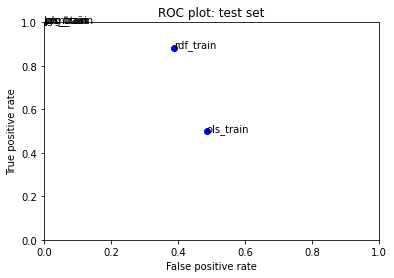

In [46]:
fits = [ols_performance_train, 
        svm_performance_train, 
        lgs_performance_train, 
#         nbs_performance_train, 
        prc_performance_train, 
        rdg_performance_train, 
        rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [47]:
ols_predictions = ols.predict(X_train)

### let's look at some false positives:

In [48]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['sentiment'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['review'])
                print('* * * * * * * * * ')


Examples of false positives:
1
Not that \a film by Ulli Lommel\" filled me with hope, but I must confess that ZODIAC KILLER managed to sink beneath my lowest expectations. There is a recent trend among young filmmakers of utilizing digital video for their early projects, which is all well and good for giving these kids the opportunity to create work without spending all their money on expensive film stock. But many of these young filmmakers have also wised up to the notion of filtering the finished movie so that it appears qualitatively more like celluloid. The effect is never perfect, but it helps. Unfiltered digital video really only works for the \"mockumentary\" style, because it never looks like anything other than video. Therein lies the primary trouble with ZODIAC KILLER. Watching the movie feels like watching a daytime soap opera about a murderer. It does not feel like watching a movie. And what's even more unforgivable is that the Lommel is NOT a young filmmaker. He ought to k

3261
I have seen most, if not all of the Laurel & Hardy classic films. I have always enjoyed there comical stupidly, even after watching it over and over again. This new film attempts to bring back the classic with two new actors who resemble both Laurel & Hardy, however fails miserably for various reasons. One of which is how out of place their cloths are (still early 20th century) however are both portrayed in the 90's setting. Some of the former dialogue was brought back, however it also fails miserably to come close to the classic series. This film could very well be the worst film I have ever seen and should be pulled off the shelf and locked away forever. The real Laurel & Hardy are surly spinning in their graves at such a bad imitation.
* * * * * * * * * 
3288
Before starting to watch the show, I've heard it was great and aesthetically very interesting. What a deception, the scripts are so dumb that I am quite sure the authors are son and grandson of Scoobidoo writers. And what 

6988
I'm into bad movies but this has NOTHING going for it. Despite what the morons above have said, it is NOT funny. I know comedy AND underground movies but this is so boring that the Director / Writer should be prohibited from EVER directing anything but local cable access EVER again! To love movies and comedy is to despise this film. I may never get over how unfunny and boring this work was. If you like this movie you ARE a pothead as sober there is NOTHING here. ZERO! If you need to compare underground movies, see \Kentucky Fried Movie\" or early John Waters. The movie starts by defining satire and I defy anyone to show me the satire. The rule for comedy is THIS ... If it's FUNNY you can say or do ANYTHING but if it's NOT funny you are not satirical, you are not edgy, you are merely pathetic and this movie is simply not funny. ZERO!"
* * * * * * * * * 
7045
This movie was a mess. It had the absolute worst editing I have ever seen. It was almost like at the end of a scene the write

10941
Look carefully at the wonderful assortment of talent put together to make this movie: Connery, Fishburne, Capshaw, Harris, Underwood, Beatty, Thigpen, even cameos by Slezak, Lange, and Plimpton. They prove, in spades, the adage that a good cast cannot save a bad script. The story line requires so many leaps of faith from the audience that its implausibility should have exceeded even Hollywood standards. It's not particularly original, and the \twists\" are downright cruel."
* * * * * * * * * 
10976
Unfortunately I made a mistake and I paid 7 Euros at the movie theater to watch this shallow meaningless movie. My points;<br /><br />Film is based on 2 things;<br /><br />1) Ethnical point of View: As it happens on most of the American Films, the writer thinks itself as an expert after learning 2 or 3 things about the Asian culture. But unfortunately it is not enough. Knowing kunefe and 2 names of other foods doesn't make a person understand a culture. For example shaving is the sign 

14839
<br /><br />I recently viewed this atrocity in my film program, and I thought it was awful, as I said in my tagline, it was pretentious, trite, petty and phenomenally self-important.<br /><br />I consider myself a fan of film, and all the things that film has to offer. If I want to watch a documentary on the Cannes Festival, I will watch A&E....and they would probably be alot more objective about it.<br /><br />I dont recommend it, period.<br /><br />
* * * * * * * * * 
14857
RKS films always have been commercial films which suited the 90's, from GHAYAL, DAMINI<br /><br />His last few films KHAKEE were watchable FAMILY was crap<br /><br />This film is a decent film but could be better<br /><br />The problem lies in there is lot of old fashioned clichés thrown in and many scenes come out too filmy and lengthy<br /><br />Ajay Devgan's character is shown very well but his character gets heroic which could be subtle<br /><br />The lengthy flashback could be avoided as thigns are simp

18940
This Charles outing is decent but this is a pretty low-key performance. Marlon Brando stands out. There's a subplot with Mira Sorvino and Donald Sutherland that forgets to develop and it hurts the film a little. I'm still trying to figure out why Charlie want to change his name. Every movie with \Charles\" has been pretty bad."
* * * * * * * * * 
18942
....ripoff of a dozen better films. Particularly Steven Martin's \LA Story\", which at least had the grace to be obviously fictional even though it starred his then-girlfriend playing his girlfriend in the film.<br /><br />Yes, naive boys and girls, \"20 Dates\" IS a mockumentary, although I am not absolutely certain that was Myles Berkowitz's intent when he started. My impression is that he started the project semi-seriously, then quickly realized that it would be pathetic and not funny unless he made the situations more and more ridiculous. As a result, the whole thing has an uneasy, cheap and insincere feeling about it.<br /><br

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [49]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 2449, 'Neg': 2551, 'TP': 1169, 'TN': 1336, 'FP': 1215, 'FN': 1280, 'Accuracy': 0.501, 'Precision': 0.4903523489932886, 'Recall': 0.47733768885259287, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [50]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 2449, 'Neg': 2551, 'TP': 2080, 'TN': 2111, 'FP': 440, 'FN': 369, 'Accuracy': 0.8382, 'Precision': 0.8253968253968254, 'Recall': 0.8493262556145366, 'desc': 'svm_test'}


### MODEL: logistic regression

In [51]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 2449, 'Neg': 2551, 'TP': 2077, 'TN': 2150, 'FP': 401, 'FN': 372, 'Accuracy': 0.8454, 'Precision': 0.8381759483454398, 'Recall': 0.8481012658227848, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [52]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

AttributeError: 'MultinomialNB' object has no attribute 'feature_log_prob_'

### MODEL: Perceptron

In [53]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 2449, 'Neg': 2551, 'TP': 2083, 'TN': 2105, 'FP': 446, 'FN': 366, 'Accuracy': 0.8376, 'Precision': 0.8236457097667063, 'Recall': 0.8505512454062882, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [54]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 2449, 'Neg': 2551, 'TP': 2040, 'TN': 2056, 'FP': 495, 'FN': 409, 'Accuracy': 0.8192, 'Precision': 0.8047337278106509, 'Recall': 0.8329930583911801, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [55]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 2449, 'Neg': 2551, 'TP': 2138, 'TN': 1544, 'FP': 1007, 'FN': 311, 'Accuracy': 0.7364, 'Precision': 0.6798092209856915, 'Recall': 0.8730093915884034, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

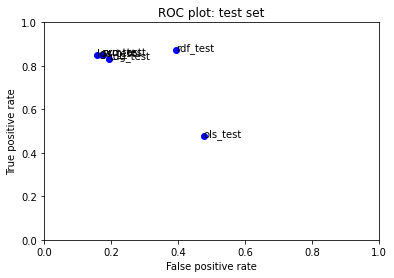

In [57]:
fits = [ols_performance_test, 
        svm_performance_test, 
        lgs_performance_test, 
#         nbs_performance_test, 
        prc_performance_test, 
        rdg_performance_test, 
        rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [59]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='../week04/final_data/moviereviews_test.tsv', my_random_seed=14, test=True)
print("Number of rows in the submission test set (should be 25,000): ")

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 2 columns 

the data types for each of the columns in movie_data:
id        object
review    object
dtype: object 

the first 10 rows in movie_data:
         id                                             review
0  12311_10  Naturally in a film who's main themes are of m...
1    8348_2  This movie is a disaster within a disaster fil...
2    5828_4  All in all, this is a movie for kids. We saw i...
3    7186_2  Afraid of the Dark left me with the impression...
4   12128_7  A very accurate depiction of small time mob li...
Shape of HashingVectorizer X:
(25000, 131072)
Look at a few rows of the new quantitative features: 
   word_count  sent_count    nltk
0         131    0.000000 -0.7913
1         169    0.500000  3.9172
2         176    1.500000 -3.9041
3         112    2.000000 -0.3397
4         133    1.333333  1.6465
5         331    0.000000  0.6067
6         121    1.333333 -0.3099
7         230    2

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [60]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = ols.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.49108


In [61]:
raw_data.head()

,id,review,word_count,sent_count,nltk
0,12311_10,Naturally in a film who's main themes are of m...,131,0.000000,-0.7913
1,8348_2,This movie is a disaster within a disaster fil...,169,0.500000,3.9172
2,5828_4,"All in all, this is a movie for kids. We saw i...",176,1.500000,-3.9041
3,7186_2,Afraid of the Dark left me with the impression...,112,2.000000,-0.3397
4,12128_7,A very accurate depiction of small time mob li...,133,1.333333,1.6465


In [62]:
my_submission.head()

,id,prediction
0,12311_10,1
1,8348_2,0
2,5828_4,0
3,7186_2,0
4,12128_7,0


In [63]:
my_submission.shape

(25000, 2)

In [64]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('my_moviereviews_submission2.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation